<a href="https://colab.research.google.com/github/shmilyface/DS-Unit-2-Applied-Modeling/blob/master/Stephanie_Miller___DS_Sprint_Challenge_8_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [0]:
!pip install category_encoders

In [0]:
import pandas as pd
import numpy as np
#model
from sklearn.linear_model import LinearRegression
#rmse calc
from sklearn.metrics import mean_squared_error
#cat encoder
from sklearn.preprocessing import OneHotEncoder
#split
from sklearn.model_selection import cross_val_score, train_test_split
#pipeline
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from math import sqrt
#xgboost
from xgboost import XGBRegressor
def rmse(act, pred):
  return sqrt(mean_squared_error(act, pred))

In [0]:
#train
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
train.columns = ['store', 'weekday', 'date', 'sales', 'customers', 'promo', 'holiday']
#test
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
test.columns = ['store', 'weekday', 'date', 'sales', 'customers', 'promo', 'holiday']
#store
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
store.columns = ['store', 'store_type', 'ass_level', 'comp_dist', 'comp_m', 'comp_y', 'promo2', 'promo2_w', 'promo2_y', 'promo_int']
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- ✓ Merge the `store` dataframe with the `train` and `test` dataframes. 
- ✓ Arrange the X matrix and y vector for the train and test sets.
- ✓ Log-transform the target for the train and test set.
- ✓ Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [0]:
#merge
train = pd.merge(train, store)
test = pd.merge(test, store)
#to datetime
train[['comp_m', 'comp_y', 'promo2_w', 'promo2_y', 'date']] = train[['comp_m', 'comp_y', 'promo2_w', 'promo2_y', 'date']].apply(pd.to_datetime)

In [0]:
train.head()

,store,weekday,date,sales,customers,promo,holiday,store_type,ass_level,comp_dist,comp_m,comp_y,promo2,promo2_w,promo2_y,promo_int
0,4,5,2015-07-31,13995,1498,1,1,c,c,620.0,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000002009,0,NaT,NaT,NaN
1,4,4,2015-07-30,10387,1276,1,1,c,c,620.0,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000002009,0,NaT,NaT,NaN
2,4,3,2015-07-29,10514,1258,1,1,c,c,620.0,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000002009,0,NaT,NaT,NaN
3,4,2,2015-07-28,10275,1191,1,1,c,c,620.0,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000002009,0,NaT,NaT,NaN
4,4,1,2015-07-27,11812,1379,1,1,c,c,620.0,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000002009,0,NaT,NaT,NaN


In [0]:
test.head()

,store,weekday,date,sales,customers,promo,holiday,store_type,ass_level,comp_dist,comp_m,comp_y,promo2,promo2_w,promo2_y,promo_int
0,10,5,2015-07-31,7185,681,1,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
1,10,4,2015-07-30,6186,556,1,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
2,10,3,2015-07-29,5524,518,1,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,10,2,2015-07-28,6140,593,1,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
4,10,1,2015-07-27,7212,662,1,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [0]:
# log transform
train['log(sales)'] = np.log(train['sales'])
test['log(sales)'] = np.log(test['sales'])

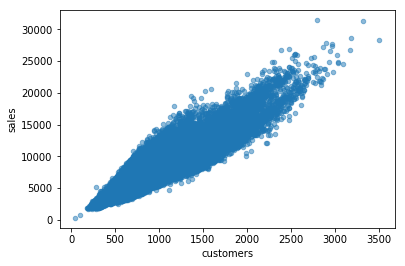

In [0]:
#before
test.plot(x='customers', y='sales', kind='scatter', alpha=0.5)

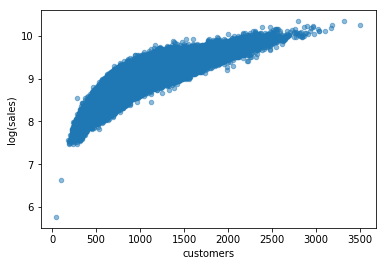

In [0]:
#after
test.plot(x='customers', y='log(sales)', kind='scatter', alpha=0.5)

In [0]:
# X matrix, y vector
train_x = train[['promo', 'customers']]
train_y = train['log(sales)']
test_x = test[['promo', 'customers']]
test_y = test['log(sales)']

## 2. Fit and validate your model
- ✓ **Use Gradient Boosting** or any type of regression model.
- ✓ **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- ✓ **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- ✓ **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [0]:
#make a plan
model = LinearRegression()
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
ugh = rmse(test_y, y_pred)
print(ugh)

0.1770667128066785


In [0]:
#stick to the plan
stores = train['store'].unique()
store_train, store_val = train_test_split(stores, random_state=42)
#pipeline split to train/val stores, and drop lame columns
def pipe_n_hot(df, options):
  df2 = df[df['store'].isin(options)].drop(columns=['date', 'comp_m', 'comp_y', 'promo2_w', 'promo2_y', 'promo_int'])
  hot = df2['log(sales)']
  return df2, hot
#train, val, test
train_pipe, train_pipe_target = pipe_n_hot(train, store_train)
val_pipe, val_pipe_target = pipe_n_hot(train, store_val)
test_pipe, test_pipe_target = pipe_n_hot(test, test['store'].unique())

In [0]:
#ALWAYS DELIVER
#pipeline
pipeline = make_pipeline(ce.OrdinalEncoder(), XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
pipeline.fit(train_pipe, train_pipe_target)
y_pred = pipeline.predict(val_pipe)
#Val Err
print('Validation error:', rmse(val_pipe_target, y_pred))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:23:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation error: 0.003760949312190671


In [0]:
#test error
y_pred2 = pipeline.predict(test_pipe)
print('Test error:', rmse(test_pipe_target, y_pred2))

Test error: 0.007900549376160448


In [0]:
#cross val scores 
scores = cross_val_score(pipeline, train_pipe, train_pipe_target)
scores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:34:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.99986984, 0.99989924, 0.99988472])

In [0]:
print('Validation Error:', rmse(val_pipe_target, y_pred))
print('Test error:', rmse(test_pipe_target, y_pred2))
print('Cross Val Scores:', scores)

Validation Error: 0.003760949312190671
Test error: 0.007900549376160448
Cross Val Scores: [0.99986984 0.99989924 0.99988472]


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [0]:
!pip install pdpbox

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

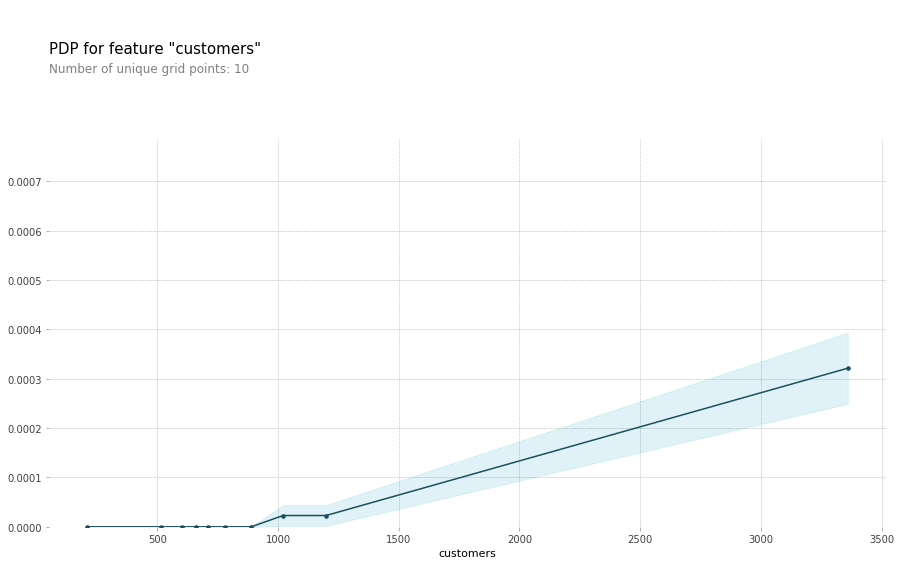

In [0]:
#customers was the more interesting graph. 
isolated = pdp_isolate(pipeline, val_pipe, val_pipe.columns, 'customers')
pdp_plot(isolated, 'customers');